In [138]:
#support imports
import os
import h5py
import random

#packages that help with plotting
import matplotlib.pyplot as plt
import scipy.stats as stats

#torch imports
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF

In [72]:
class HDF5Dataset(Dataset):
    def __init__(self, file_path,transform=None):
        self.file_path = file_path
        self.hdf5_file = h5py.File(file_path,'r')
        self.images = self.hdf5_file['X']
        self.labels = self.hdf5_file['y']
        self.transform = transform
    
    def __len__(self):
        return(len(self.labels))
    
    def __getitem__(self,idx):
        image = torch.tensor(self.images[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)
            
        return image,label

In [81]:
#custom transform to reshape the image tensor

class ReshapeImage(object):
    def __call__(self,image):
        return image.permute(2,0,1)

In [132]:
transform = transforms.Compose([
    ReshapeImage(),
    transforms.CenterCrop(16)
])

In [133]:
electron_dataset = HDF5Dataset('./data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5', transform=transform)
photon_dataset = HDF5Dataset('./data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5',transform=transform)

In [134]:
def show_images(dataset ,num_images=3):
    fig,axes = plt.subplots(1, num_images, figsize=(15,5))
    idx_arr = [167832,73473,637]
    
    for i in range(num_images):
        # idx = random.randint(0,len(dataset)-1)
        idx = idx_arr[i]
        
        image,_ = dataset.__getitem__(idx)
        # image_transpose = image.transpose(0,2)
        image_pil = TF.to_pil_image(image)
        
        axes[i].imshow(image_pil, cmap='binary')
        # axes[i].axis('off')
        
    plt.show()

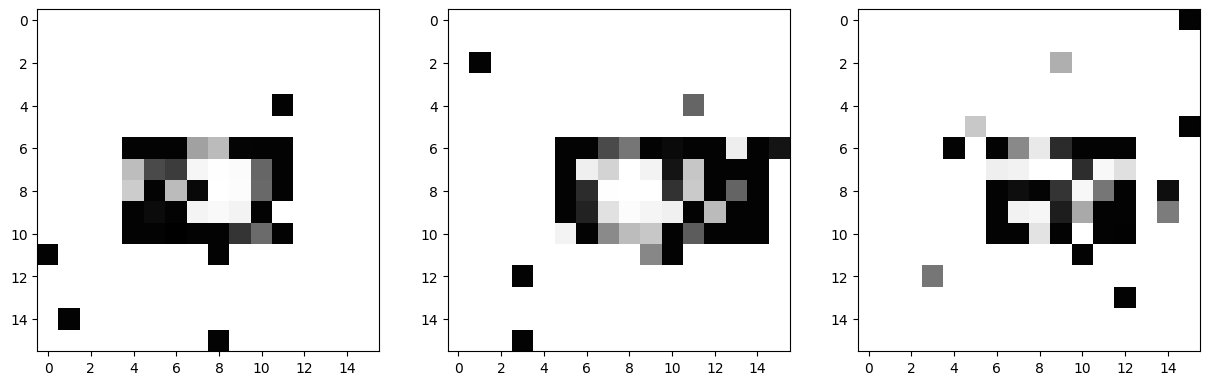

In [135]:
show_images(photon_dataset)

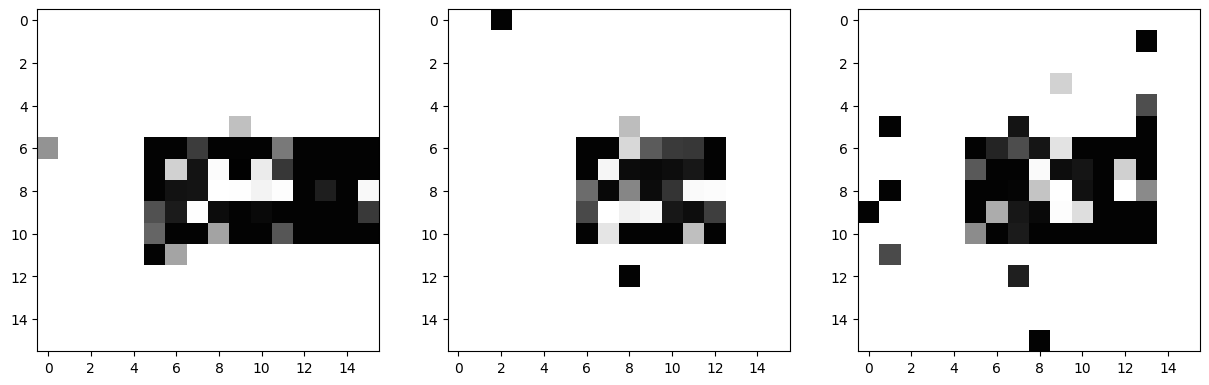

In [136]:
show_images(electron_dataset)

In [137]:
sample,_ = photon_dataset.__getitem__(1)
print(sample.shape)

torch.Size([2, 16, 16])
